 Rectified Flow proposed in '[Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/abs/2209.03003)'.

The problem here is to learn an ODE $\dot Z_t = v(Z_t, t) $ to transfer data from $\pi_0$ to $\pi_1$, where both $\pi_0$ and $\pi_1$ are unknown and empirically observed through a set of points.

The velocity field $v(z,t)$ in rectified flow can be fitted with either kernel method or deep neural networks. This tutorial illustrates the trainining based on neural network.

## Generating Distribution $\pi_0$ and $\pi_1$
We generate $\pi_0$ and $\pi_1$ as two Gaussian mixture models with different modes.

We sample 10000 data points from $\pi_0$ and $\pi_1$, respectively,
and store them in ```samples_0```, ```samples_1```.

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from sklearn.datasets import make_circles, make_checkerboard
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.log_normal import LogNormal
from torch.distributions.independent import Independent
from torch.distributions.pareto import Pareto
from torch.distributions.studentT import StudentT
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm

Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])


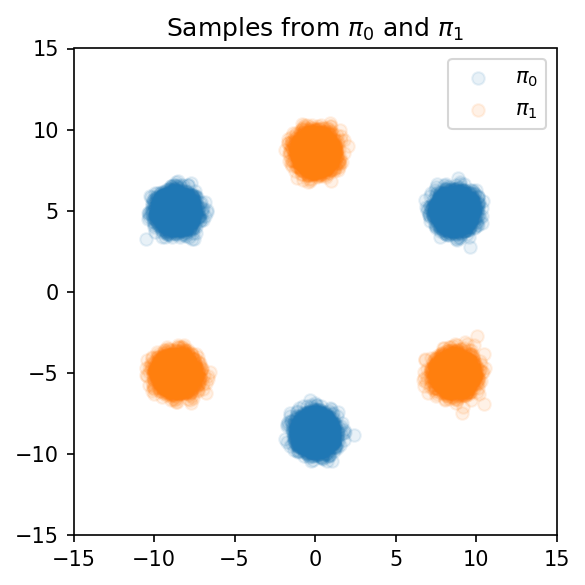

In [2]:
D = 10  # scale factor
M = 15  # x, y axes limits
VAR = 0.3 
DOT_SIZE = 4
COMP = 3 # number of components in each GMM

initial_mix = Categorical(torch.tensor([1/COMP for _ in range(COMP)])) # initial_mixing_coefficients
initial_comp = MultivariateNormal(torch.tensor([
                  [D * np.sqrt(3) / 2., D / 2.],
                  [-D * np.sqrt(3) / 2., D / 2.],
                  [0.0, - D * np.sqrt(3) / 2.]]).float(),    # mu
    VAR * torch.stack([torch.eye(2) for _ in range(COMP)]))  # var
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1/COMP for _ in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([
                  [D * np.sqrt(3) / 2., - D / 2.],
                  [-D * np.sqrt(3) / 2., - D / 2.],
                  [0.0, D * np.sqrt(3) / 2.]]).float(),
    VAR * torch.stack([torch.eye(2) for _ in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

plt.figure(figsize=(4,4), dpi=150)
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')  # pi_0, blue
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')  # pi_1,
plt.legend()

plt.tight_layout()

In [3]:
initial_mix.probs, initial_mix.logits

(tensor([0.3333, 0.3333, 0.3333]), tensor([-1.0986, -1.0986, -1.0986]))

In [4]:
target_mix.probs, target_mix.logits

(tensor([0.3333, 0.3333, 0.3333]), tensor([-1.0986, -1.0986, -1.0986]))

In [5]:
initial_comp

MultivariateNormal(loc: torch.Size([3, 2]), covariance_matrix: torch.Size([3, 2, 2]))

In [6]:
initial_comp.loc, initial_comp.covariance_matrix

(tensor([[ 8.6603,  5.0000],
         [-8.6603,  5.0000],
         [ 0.0000, -8.6603]]),
 tensor([[[0.3000, 0.0000],
          [0.0000, 0.3000]],
 
         [[0.3000, 0.0000],
          [0.0000, 0.3000]],
 
         [[0.3000, 0.0000],
          [0.0000, 0.3000]]]))

In [7]:
target_comp.loc, initial_comp.covariance_matrix

(tensor([[ 8.6603, -5.0000],
         [-8.6603, -5.0000],
         [ 0.0000,  8.6603]]),
 tensor([[[0.3000, 0.0000],
          [0.0000, 0.3000]],
 
         [[0.3000, 0.0000],
          [0.0000, 0.3000]],
 
         [[0.3000, 0.0000],
          [0.0000, 0.3000]]]))

# Why

## Define the Flow Model
Given empirical observations of $X_0\sim \pi_0$ and $X_1\sim \pi_1$,
the rectified flow induced from $(X_0,X_1)$
is an ordinary differentiable model (ODE)
on time $t\in[0,1]$,
$$
\mathrm d Z_t = v^X(Z_t, t) \mathrm d t,
$$
which $v$ is set in a way that ensures that $Z_1$ follows $\pi_1$ when $Z_0 \sim \pi_0$. Let $X_t = t X_1 + (1-t)X_0$ be the linear interpolation of $X_0$ and $X_1$. Then $v$ is given by
$$
v^X(z,t) = \mathbb{E}[X_1 - X_0 ~|~ X_t = z  ] =  \arg\min_{v} \int_0^1 \mathbb{E}[|| X_1-X_0 - v(X_t,t) ||^2] \mathrm{d} t,
$$
where the (conditional) expectation is w.r.t. the joint distribution of $(X_0,X_1)$.

We parameterize $v^X(z,t)$ with a 3-layer neural network.

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

Then we define the rectified flow class.

In [9]:
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0   # Linear Intropolation
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]
    print(f"z0 shape {z0.shape}")
    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt # z = z + vdt，flow的点

      traj.append(z.detach().clone()) # 保存flow点

    return traj

In [10]:
torch.rand((3, 1))

tensor([[0.0826],
        [0.8493],
        [0.7478]])

## Define the training method and other misc. code
We define the training method here. The loss function is:
$$
\min_{\theta}
\int_0^1 \mathbb{E}\left [ {||( X_1 - X_0) - v_\theta\big (X_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
X_t = t X_1 + (1-t) X_0,
$$
where $\mathbb{E}[\cdot]$ is approximated by empirical draws of $(X_0,X_1)$,
and $t$ by drawing from the uniform distribution on $[0,1]$.

In [11]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  # for i in range(inner_iters+1):
  for _ in tqdm(range(inner_iters+1)):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    # print(f'indices:{indices}.')
    batch = pairs[indices]
    # print(f'batch:{batch}.')
    z0 = batch[:, 0].detach().clone()
    # print(z0.shape)
    z1 = batch[:, 1].detach().clone()
    # print(z1.shape)
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
    # print("p",pred.shape)     [batch_size, 2]
    # print("t",target.shape)   [batch_size, 2]
    # loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = (target - pred).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()

    # cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    # cosine_loss = 1 - cos(pred, target).mean()
    # cosine_loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve
    # loss_curve.append(np.log(cosine_loss.item())) ## to store the loss curve


  return rectified_flow, loss_curve

In [12]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
    
  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  print(traj_particles.shape)  # [101, 2000, 2]
  print(traj_particles)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(20):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

## 1-Rectified Flow
We start by generating the pairs $(X_0, X_1)$ by pooling randomly sampled points from ```sample_0``` and ```sample_1```. So $(X_0,X_1)$ forms an independent coupling of $\pi_0$ and $\pi_1$.


In [13]:
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)
print(x_pairs.shape)

torch.Size([10000, 2, 2])


In [14]:
torch.randperm(len(samples_0))

tensor([9407, 1281, 9648,  ..., 9800, 2124, 3620])

In [15]:
samples_0.detach().clone().size()

torch.Size([10000, 2])

In [16]:
x_pairs

tensor([[[ 0.2418, -8.1652],
         [-8.5067, -4.9622]],

        [[-9.2071,  4.9463],
         [-8.6053, -4.3354]],

        [[-9.0477,  5.2563],
         [ 9.3954, -4.3460]],

        ...,

        [[-8.1875,  4.7524],
         [-8.8668, -4.4199]],

        [[ 7.0115,  5.1431],
         [-7.8297, -4.3553]],

        [[-1.4418, -8.1903],
         [-8.9637, -4.5844]]])

In [17]:
model = MLP(input_dim=2, hidden_num=100)
print(model)

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


  0%|          | 0/10001 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Training Loss Curve')

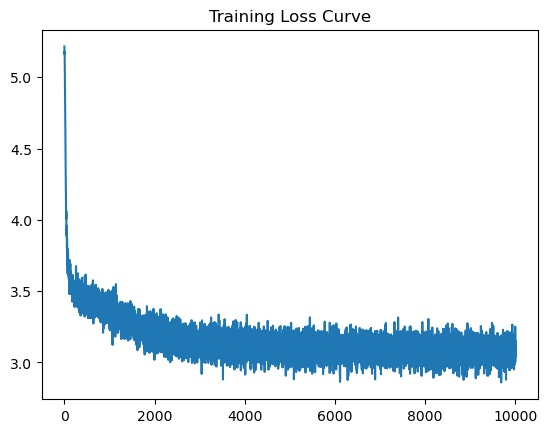

In [18]:
#
iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

In [19]:
traj = rectified_flow_1.sample_ode(z0=samples_0.detach().clone()[:10], N=100)

z0 shape torch.Size([10, 2])


We run the Euler method to solve the ODE with $N=100$ steps to generate samples from 1-Rectified Flow.

Orange dots = samples from $\pi_0$

Blue dots   = samples from $\pi_1$

Green dots  = samples from 1-Rectified Flow

1-Rectified Flow successfully learned a velocity field $v(Z_t, t)$ that can transport $\pi_0$ to $\pi_1$.

z0 shape torch.Size([2000, 2])
torch.Size([101, 2000, 2])
tensor([[[-9.1490,  4.7836],
         [-0.5544, -8.7726],
         [-8.4254,  4.2099],
         ...,
         [-8.6044,  4.8631],
         [-1.1378, -8.6117],
         [ 8.6029,  5.1141]],

        [[-9.0854,  4.7118],
         [-0.5557, -8.6927],
         [-8.3253,  4.1389],
         ...,
         [-8.5230,  4.8026],
         [-1.1607, -8.5325],
         [ 8.5177,  5.0601]],

        [[-9.0271,  4.6359],
         [-0.5622, -8.6118],
         [-8.2223,  4.0642],
         ...,
         [-8.4408,  4.7401],
         [-1.1904, -8.4536],
         [ 8.4311,  5.0073]],

        ...,

        [[-9.0447, -5.1869],
         [-7.9985, -5.4502],
         [-7.6342, -4.7822],
         ...,
         [-8.3214, -4.6491],
         [-8.9069, -5.5151],
         [ 0.2374,  8.3793]],

        [[-9.1079, -5.2433],
         [-8.0687, -5.4925],
         [-7.7212, -4.8568],
         ...,
         [-8.3917, -4.7175],
         [-8.9761, -5.5638],
         

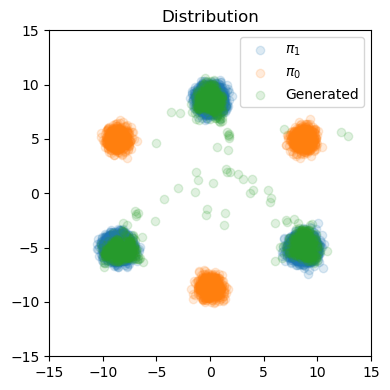

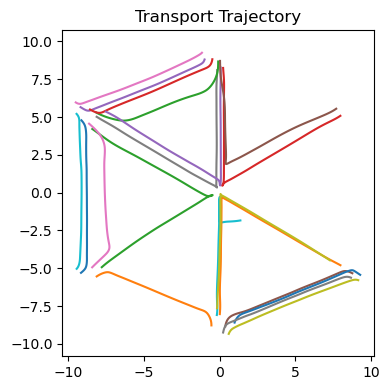

In [20]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)

We can see that the trajectories above fit well on the trajectories of linear intepolation of data, but are "rewired" in the center when the trajectories are intersect. Hence, the resulting trajectories are either (almost)straight, or has a ">" shape. 

Due to the non-straight ">"-shape paths, if we simulate the ODE with a small step $N$, we would obtain poor performance, as shown below ($N=1$). 

z0 shape torch.Size([2000, 2])
torch.Size([2, 2000, 2])
tensor([[[ 9.9464,  5.6238],
         [-8.9966,  5.1503],
         [-0.1224, -9.3564],
         ...,
         [-8.5290,  5.2119],
         [-1.1125, -7.7631],
         [-0.9205, -9.4560]],

        [[ 2.4493,  0.2257],
         [-1.4151, -0.4661],
         [ 0.8157, -0.3499],
         ...,
         [-0.2389,  0.0238],
         [-0.1111,  1.0631],
         [-3.7517, -2.3672]]])


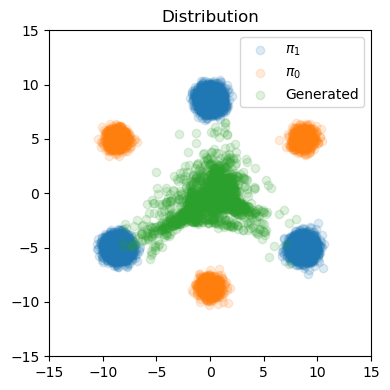

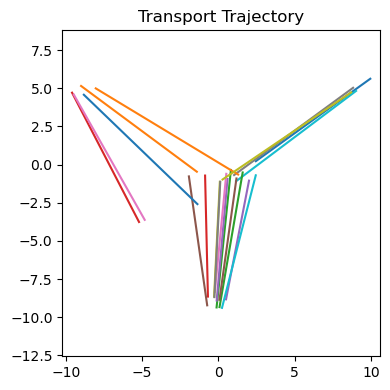

In [21]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=1)